# 機器學習百日馬拉松期中練習測驗 
https://www.kaggle.com/c/ml100marathon-02-01/

### Data
本賽題提供用戶在2016年1月1日至2016年5月31日之間真實線下消費行為，預測用戶在2016年6月領取優惠券後15天以內的使用情況。

### Evaluation
本賽題目標是預測投放的優惠券是否在規定時間內核銷。針對此任務及一些相關背景知識，以該用戶使用於某日取得之優惠券核銷預測 AUC（ROC 曲線下面積）作為評價標準。即對將 User_id - Date_received - Coupon_id 為一組計算核銷預測的AUC值，若某使用者於同一日取得多張相同優惠券，則任一張核銷皆為有效核銷。

### 欄位說明 (與 column_description.csv 相同) 
- User_id：用戶 ID 
- Merchant_id：商家 ID 
- Coupon_id：優惠券 ID (null 代表無優惠券消費) 
- Discount_rate：優惠券折價：[0,1] 代表折扣率；x:y 代表滿 x 減 y 元 
- Distance：用戶經常活動地點離商家最近距離 (x * 500 公尺), 0 表示低於 500 公尺, 10 表示大於 5 公里。 
- Date_received：優惠券取得時間。 
- Date：購買商品時間 (如果 Date is null & Coupon_id is not null, 則該紀錄為有優惠券但未使用; 若為 Date is not null & Coupon_id is null, 則為普通消費日期; 若 Date is not null & Coupon_id is not null, 則表示優惠券消費日期)

In [13]:
# 載入基本套件
import os
import numpy as np
import pandas as pd
import copy, time, random, datetime
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
from IPython.display import display
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LinearRegression, LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.regressor import StackingRegressor, StackingCVRegressor
from mlxtend.classifier import StackingClassifier, StackingCVClassifier
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score, auc, roc_curve
from sklearn import metrics, model_selection
from scipy import stats
from scipy.stats import mode
import xgboost as xgb

# 忽略警告
import warnings
warnings.simplefilter('ignore')

# 讀取訓練與測試資料
data_path = 'data/'
df_train = pd.read_csv(data_path + 'train_offline.csv')
df_test = pd.read_csv(data_path + 'test_offline.csv')
df_train = df_train[~df_train.Date_received.isna()] # 移除未取得優惠卷之測試資料
df_test = df_test[~df_test.Date_received.isna()] # 移除未取得優惠卷之測試資料
# df_test = df_test[:5000]
# df_train = df_train[:5000]
print(df_train.shape)
print(df_test.shape)

(746969, 7)
(306313, 6)


In [14]:
## 建立目標值：用戶在2016年6月領取優惠券後15天以內的使用情況
""" 
1) 使用優惠卷消費 在15天內 ==> 1
2) 使用優惠卷消費 超過15天 ==> 0
3) 未使用優惠卷消費 ==> -1 (移除，以2分法分類)
"""
def label(row):
    if np.isnan(row['Date_received']):
        return -1
    if not np.isnan(row['Date']):
        td = pd.to_datetime(row['Date'], format='%Y%m%d') -  pd.to_datetime(row['Date_received'], format='%Y%m%d')
        if td <= pd.Timedelta(15, 'D'):
            return 1
    return 0

df_train['Label'] = df_train.apply(label, axis=1)
train_Y = df_train['Label']
train_num = train_Y.shape[0]
print(df_train['Label'].value_counts())

df_train = df_train.drop(['Label'] , axis=1) #train_X
df = pd.concat([df_train,df_test])
print(df.shape)

0    710665
1     36304
Name: Label, dtype: int64
(1053282, 7)


In [15]:
# 檢查 DataFrame 空缺值的狀態
def na_check(df_data):
    print(df_data.isnull().sum().sort_values(ascending=False).head(10))
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data.head(10))
na_check(df)

Date             1010346
Distance          106003
User_id                0
Merchant_id            0
Discount_rate          0
Date_received          0
Coupon_id              0
dtype: int64


,Missing Ratio
Date,95.923599
Distance,10.064066


In [16]:
# 確定只有 int64, float64, object 三種類型後對欄位名稱執行迴圈, 分別將欄位名稱存於三個 list 中
int_features = []
float_features = []
object_features = []
# .dtypes(欄位類型), .columns(欄位名稱) 是 DataFrame 提供的兩個方法, 這裡順便展示一下 for 與 zip 搭配的用法
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64':
        float_features.append(feature)
    elif dtype == 'int64':
        int_features.append(feature)
    else:
        object_features.append(feature)
print(f'{len(int_features)} Integer Features : {int_features}\n')
print(f'{len(float_features)} Float Features : {float_features}\n')
print(f'{len(object_features)} Object Features : {object_features}')

2 Integer Features : ['Merchant_id', 'User_id']

4 Float Features : ['Coupon_id', 'Date', 'Date_received', 'Distance']

1 Object Features : ['Discount_rate']


In [17]:
# 統計特定類型的相異值數量
df[float_features].nunique().sort_values(ascending=False)

Coupon_id        9738
Date              176
Date_received     167
Distance           11
dtype: int64

In [18]:
# 部分欄位缺值缺值補 'None'
none_cols = ['Date']
for col in none_cols:
    df[col] = df[col].fillna(20991231)

# 'Distance' 有空缺時, 以同一商家 (Merchant_id) 的 Distance 中位數填補 (可以視為填補一種群聚編碼 )
df["Distance"] = df["Distance"] +1
df["Distance"] = df.groupby("Merchant_id")["Distance"].transform(lambda x: x.fillna(x.median()))

# 填補平均值(Mean) : 數值型欄欄位，偏態不明顯；填補中位數(Median) : 數值型欄欄位，偏態很明顯
median_cols = ['Distance']
for col in median_cols:
    df[col] = df[col].fillna(df[col].median())

# 做完各種補缺值, 確認一下有沒有遺漏
na_check(df)

User_id          0
Merchant_id      0
Distance         0
Discount_rate    0
Date_received    0
Date             0
Coupon_id        0
dtype: int64


,Missing Ratio


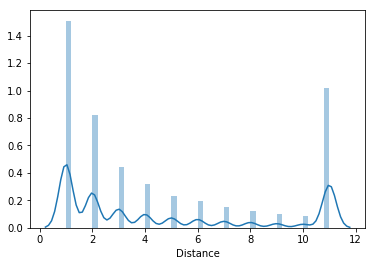

,Coupon_id,Date,Date_received,Discount_rate,Distance,Merchant_id,User_id
1,8591.0,20991231.0,20160217.0,20:1,1.0,2632,1439408
2,1078.0,20991231.0,20160319.0,20:1,1.0,2632,1439408
3,7610.0,20991231.0,20160429.0,200:20,1.0,3381,1832624
4,11951.0,20991231.0,20160129.0,200:20,2.0,3381,2029232
5,9776.0,20991231.0,20160129.0,10:5,3.0,3381,2223968


In [19]:
# 顯示 Distance 的散佈圖
sns.distplot(df['Distance'][:train_num])
plt.show()

# 將 Distance 取 boxcox 後, 看散佈圖
# df['Distance'] = stats.boxcox(df['Distance']+1, lmbda=0.2)
# sns.distplot(df['Distance'])
# plt.show()

df.head()

In [20]:
# 加入優惠卷特徵，優惠卷分為折扣類和滿額類；[0~1] 代表折扣率；x:y 代表滿 x 減 y 元 
def discount_type(row): # 優惠卷型式，滿額折價較不吸引人使用
    if ':' in row:
        return 1
    else:
        return 0
def convert_rate(row): # 折扣類優惠卷，轉為折扣率
    if ':' in row:
        rows = row.split(':')
        return 1 - float(rows[1])/float(rows[0])
    else:
        return float(row)
def amount_buy(row): # 滿額類優惠卷的使用門檻
    if ':' in row:
        rows = row.split(':')
        return int(rows[0])
    else:
        return 0

def amount_discount(row): # 滿額類優惠卷的折扣金額
    if ':' in row:
        rows = row.split(':')
        return int(rows[1])
    else:
        return 0
df['Discount_type'] = df['Discount_rate'].astype('str').apply(discount_type)
df['Discount_%'] = df['Discount_rate'].astype('str').apply(convert_rate)
df['Amount_Buy'] = df['Discount_rate'].astype('str').apply(amount_buy)
df['Amount_Dis'] = df['Discount_rate'].astype('str').apply(amount_discount)

df = df.drop(['Discount_rate'] , axis=1)
df.head(10)

,Coupon_id,Date,Date_received,Distance,Merchant_id,User_id,Discount_type,Discount_%,Amount_Buy,Amount_Dis
1,8591.0,20991231.0,20160217.0,1.0,2632,1439408,1,0.95,20,1
2,1078.0,20991231.0,20160319.0,1.0,2632,1439408,1,0.95,20,1
3,7610.0,20991231.0,20160429.0,1.0,3381,1832624,1,0.90,200,20
4,11951.0,20991231.0,20160129.0,2.0,3381,2029232,1,0.90,200,20
5,9776.0,20991231.0,20160129.0,3.0,3381,2223968,1,0.50,10,5
6,12034.0,20991231.0,20160207.0,2.0,2099,73611,1,0.90,100,10
7,5054.0,20991231.0,20160421.0,11.0,1569,163606,1,0.85,200,30
8,7802.0,20991231.0,20160130.0,11.0,4833,3273056,1,0.90,200,20
9,7610.0,20991231.0,20160412.0,3.0,3381,94107,1,0.90,200,20
11,7531.0,20991231.0,20160327.0,1.0,8390,253750,1,0.75,20,5


In [21]:
# 是否使用優惠卷類別，是=1，否=0
def use_coupon(row):
    if row['Date'] != 20991231:
        return 1
    return 0
df['Use'] = df.apply(use_coupon, axis=1)

# 加入計數編碼：[Merchant_id, User_id]對'是否有使用優惠卷'做計數編碼
count_df = df.groupby(['Merchant_id'])['Use'].agg({'Merchant_count':'size'}).reset_index()
df = pd.merge(df, count_df, on=['Merchant_id'], how='left')
print(count_df.sort_values(by=['Merchant_count'], ascending=False).head(5))

# 加入User_id計數編碼
count_df = df.groupby(['User_id'])['Use'].agg({'User_count':'size'}).reset_index()
df = pd.merge(df, count_df, on=['User_id'], how='left')
print(count_df.sort_values(by=['User_count'], ascending=False).head(5))

df = df.drop(['Merchant_id', 'User_id', 'Use', 'Coupon_id'] , axis=1)

      Merchant_id  Merchant_count
2135         3381          122834
281           450           63042
482           760           44976
3368         5341           36162
1707         2709           35330
        User_id  User_count
460801  6641735         120
190299  2751537         119
350192  5054119          96
480797  6929894          95
196443  2839484          83


In [22]:
# 加入時間特徵：取得優惠卷時間
def get_weekday(row):
    return pd.to_datetime(row, format = "%Y%m%d").dayofweek +1 # 加 1 讓日週期編碼從 0~6 變成 1~7

df['Weekday'] = df['Date_received'].apply(get_weekday)
df['Useday'] = df['Date'].apply(get_weekday)

# 取得或使用優惠卷日週期類別，假日=1，和非假日=0
df['Weekday_type'] = df['Weekday'].apply(lambda x : 1 if x in [6,7] else 0 )
df['Useday_type'] = df['Useday'].apply(lambda x : 1 if x in [6,7] else 0 )

print(df['Weekday_type'].value_counts())
print(df['Useday_type'].value_counts())

0    700457
1    352825
Name: Weekday_type, dtype: int64
0    1039990
1      13292
Name: Useday_type, dtype: int64


In [23]:
# 加入時間特徵：取得優惠卷後多久使用
def think_day(row):
    td = pd.to_datetime(row['Date'], format='%Y%m%d') -  pd.to_datetime(row['Date_received'], format='%Y%m%d')
    if td <= pd.Timedelta(4, 'D'):
        return 3
    elif td <= pd.Timedelta(8, 'D'):
        return 2
    elif td <= pd.Timedelta(15, 'D'):
        return 1
    return 0
df['Thinkday'] = df.apply(think_day, axis=1)
print(df['Thinkday'].value_counts())

0    1016978
3      18835
2      10949
1       6520
Name: Thinkday, dtype: int64


In [24]:
# 特徵組合：優惠卷吸引人的程度，距離遠近 x 購買門檻
df['Attraction'] = df['Distance'] * df['Amount_Buy']
df.head()

,Date,Date_received,Distance,Discount_type,Discount_%,Amount_Buy,Amount_Dis,Merchant_count,User_count,Weekday,Useday,Weekday_type,Useday_type,Thinkday,Attraction
0,20991231.0,20160217.0,1.0,1,0.95,20,1,43,5,3,4,0,0,0,20.0
1,20991231.0,20160319.0,1.0,1,0.95,20,1,43,5,6,4,1,0,0,20.0
2,20991231.0,20160429.0,1.0,1,0.90,200,20,122834,1,5,4,0,0,0,200.0
3,20991231.0,20160129.0,2.0,1,0.90,200,20,122834,3,5,4,0,0,0,400.0
4,20991231.0,20160129.0,3.0,1,0.50,10,5,122834,1,5,4,0,0,0,30.0


In [25]:
# 吸引力(Attraction)對使用日型態(Useday_type)做群聚編碼  
# 寫法類似均值編碼, 只是對另一個特徵, 而非目標值
mean_df = df.groupby(['Useday_type'])['Attraction'].mean().reset_index()
mode_df = df.groupby(['Useday_type'])['Attraction'].apply(lambda x: x.mode()[0]).reset_index()
median_df = df.groupby(['Useday_type'])['Attraction'].median().reset_index()
max_df = df.groupby(['Useday_type'])['Attraction'].max().reset_index()
temp = pd.merge(mean_df, mode_df, how='left', on=['Useday_type'])
temp = pd.merge(temp, median_df, how='left', on=['Useday_type'])
temp = pd.merge(temp, max_df, how='left', on=['Useday_type'])
temp.columns = ['Useday_type', 'UT_Mean', 'UT_Mode', 'UT_Median', 'UT_Max']
df = pd.merge(df, temp, how='left', on=['Useday_type'])
df.head()

,Date,Date_received,Distance,Discount_type,Discount_%,Amount_Buy,Amount_Dis,Merchant_count,User_count,Weekday,Useday,Weekday_type,Useday_type,Thinkday,Attraction,UT_Mean,UT_Mode,UT_Median,UT_Max
0,20991231.0,20160217.0,1.0,1,0.95,20,1,43,5,3,4,0,0,0,20.0,369.860991,30.0,150.0,3300.0
1,20991231.0,20160319.0,1.0,1,0.95,20,1,43,5,6,4,1,0,0,20.0,369.860991,30.0,150.0,3300.0
2,20991231.0,20160429.0,1.0,1,0.90,200,20,122834,1,5,4,0,0,0,200.0,369.860991,30.0,150.0,3300.0
3,20991231.0,20160129.0,2.0,1,0.90,200,20,122834,3,5,4,0,0,0,400.0,369.860991,30.0,150.0,3300.0
4,20991231.0,20160129.0,3.0,1,0.50,10,5,122834,1,5,4,0,0,0,30.0,369.860991,30.0,150.0,3300.0


In [26]:
# 四個數值欄位, 因為相異值有限, 轉成文字
label_cols = ['Date', 'Date_received']
for col in label_cols:
    df[col] = df[col].astype(str)

# 相異值不太具有代表性的, 做標籤編碼
cols = ('Date', 'Date_received')
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(df[c].values)) 
    df[c] = lbl.transform(list(df[c].values))

# 把剩下少數重要的類別型欄位, 做獨熱編碼 (已變成數字的欄位, 會自動跳過)
df = pd.get_dummies(df)

# 看看目前特徵工程的結果
print('Shape df: {}'.format(df.shape))
df.head()

Shape df: (1053282, 19)


,Date,Date_received,Distance,Discount_type,Discount_%,Amount_Buy,Amount_Dis,Merchant_count,User_count,Weekday,Useday,Weekday_type,Useday_type,Thinkday,Attraction,UT_Mean,UT_Mode,UT_Median,UT_Max
0,176,47,1.0,1,0.95,20,1,43,5,3,4,0,0,0,20.0,369.860991,30.0,150.0,3300.0
1,176,78,1.0,1,0.95,20,1,43,5,6,4,1,0,0,20.0,369.860991,30.0,150.0,3300.0
2,176,119,1.0,1,0.90,200,20,122834,1,5,4,0,0,0,200.0,369.860991,30.0,150.0,3300.0
3,176,28,2.0,1,0.90,200,20,122834,3,5,4,0,0,0,400.0,369.860991,30.0,150.0,3300.0
4,176,28,3.0,1,0.50,10,5,122834,1,5,4,0,0,0,30.0,369.860991,30.0,150.0,3300.0


In [27]:
# 將前述轉換完畢資料 df , 重新切成 train_X, test_X
train_num = train_Y.shape[0]
train_X = df[:train_num]
test_X = df[train_num:]
# 因為訓練邏輯斯迴歸時也要資料, 因此將訓練及切成三部分 train / val / test, 採用 test 驗證而非 k-fold 交叉驗證
# train 用來訓練梯度提升樹, val 用來訓練邏輯斯迴歸, test 驗證效果
train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y, test_size=0.5)

In [ ]:
# 使用三種模型 : 邏輯斯回歸 / 梯度提升機 / 隨機森林, 參數使用 Random Search 尋找
RANDOM_SEED = 42
n_iter=100
n_jobs=-1
'''gdbt = GradientBoostingClassifier(random_state=RANDOM_SEED)
param_dist_gdbt = {'learning_rate':[0.01,0.03,0.05],
              'max_depth':range(3,15,1),
              'max_features':range(1,5,1),
              'n_estimators':range(50,400,25)
              }
random_search_gdbt = RandomizedSearchCV(gdbt, param_dist_gdbt, scoring='roc_auc', n_iter=n_iter, n_jobs=n_jobs, cv=5)
random_result_gdbt = random_search_gdbt.fit(train_X, train_Y)
print("GDBT Best Score: %1.3f using %s" % (random_result_gdbt.best_score_, random_result_gdbt.best_estimator_))
lr = LogisticRegression()
param_dist_lr = {'C': np.linspace(.0001, 1000, 200) , 'penalty': [ "l1", "l2"]}
random_search_lr = RandomizedSearchCV(lr, param_dist_lr, scoring='roc_auc', n_iter=n_iter, n_jobs=n_jobs, cv=5)
random_result_lr = random_search_lr.fit(train_X, train_Y)
print("LR Best Score: %1.3f using %s" % (random_result_lr.best_score_, random_result_lr.best_estimator_))
rf = RandomForestClassifier(random_state=RANDOM_SEED)
param_dist_rf = {'bootstrap':[True,False],
              'max_depth':range(3,15,1),
              'max_features':range(1,5,1),
              'n_estimators':range(50,300,10)
              }
random_search_rf = RandomizedSearchCV(rf, param_dist_rf, scoring='roc_auc', n_iter=n_iter, n_jobs=n_jobs, cv=5)
random_result_rf = random_search_rf.fit(train_X, train_Y)
print("RF Best Score: %1.3f using %s" % (random_result_rf.best_score_, random_result_rf.best_estimator_))'''
clf = xgb.XGBClassifier(random_state=RANDOM_SEED)
param_dist_xgb = {'learning_rate':[0.01,0.03,0.05],
              'max_depth':range(3,15,1),
              'n_estimators':range(50,400,25),
              'subsample':np.linspace(0.7,0.9,20),
              'colsample_bytree':np.linspace(0.5,0.98,10),
              'min_child_weight':range(1,9,1)
                 }
random_search_xgb = RandomizedSearchCV(clf, param_dist_xgb, scoring='roc_auc', n_iter=n_iter, n_jobs=n_jobs, cv=5)
random_result_xgb = random_search_xgb.fit(train_X, train_Y)
print("XGB Best Score: %1.3f using %s" % (random_result_xgb.best_score_, random_result_xgb.best_estimator_))

In [28]:
gdbt = GradientBoostingClassifier(n_estimators=250, max_features=2, max_depth=3, learning_rate=0.05)
lr = LogisticRegression(C=683.4171170854271, penalty='l1')
rf = RandomForestClassifier(bootstrap=False, max_depth=11, max_features=3, n_estimators=50)
clf = xgb.XGBClassifier(colsample_bytree=0.7666666666666666,
              learning_rate=0.01, max_depth=8,
              min_child_weight=3, n_estimators=350, random_state=42,
              subsample=0.7210526315789473)
print("cross_val_score: %1.3f" % (cross_val_score(clf, val_X, val_Y, cv=5).mean()))

cross_val_score: 1.000


In [29]:
# 模式預測檔 
clf.fit(train_X, train_Y)
auc_score = roc_auc_score(y_true=val_Y, y_score=clf.predict_proba(val_X)[:,1])
acc = accuracy_score(y_true=val_Y, y_pred=clf.predict_proba(val_X).argmax(axis=1))
print("Validation AUC: {:.3f}, Accuracy: {:.3f}".format(auc_score, acc))

clf_pred = clf.predict_proba(test_X)[:, 1]
clf_pred.shape[0]

Validation AUC: 1.000, Accuracy: 1.000


306313

In [30]:
# 梯度提升機預測檔
gdbt.fit(train_X, train_Y)
gdbt_pred = gdbt.predict_proba(test_X)[:, 1]
# 隨機森林預測檔
rf.fit(train_X, train_Y)
rf_pred = rf.predict_proba(test_X)[:, 1]
# 混合泛化預測檔 (依 Kaggle 傳回分數調整比重, 越準確者比重越高, 依資料性質有所不同)
clf_pred = rf_pred*0.05 + clf_pred*0.75 + gdbt_pred*0.2

In [31]:
# 計算提交結果
output = pd.DataFrame()
output['User_id'] = df_test['User_id'].astype('str')
output['Coupon_id'] = df_test['Coupon_id'].astype('int').astype('str')
output['Date_received'] = df_test['Date_received'].astype('int').astype('str')
output['uid'] = output[['User_id', 'Coupon_id', 'Date_received']].apply(lambda x: '_'.join(x.values), axis=1)
output.head()

,User_id,Coupon_id,Date_received,uid
0,1439408,11002,20160528,1439408_11002_20160528
1,1439408,8591,20160613,1439408_8591_20160613
3,1439408,8591,20160516,1439408_8591_20160516
4,2029232,1532,20160530,2029232_1532_20160530
5,2029232,12737,20160519,2029232_12737_20160519


In [32]:
submit = pd.DataFrame()
submit['uid'] = output['uid']
submit['label'] = clf_pred
submit = submit.groupby("uid", as_index=False).mean()
submit.head()

,uid,label
0,1000020_2705_20160519,0.011834
1,1000020_8192_20160513,0.011774
2,1000065_1455_20160527,0.011606
3,1000085_8067_20160513,0.011596
4,1000086_2418_20160613,0.011641


In [33]:
submit.to_csv('data/D051_MiddleExamv3.csv',index=False)